New PDG 2 (Detail)

In [ ]:
import os
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, GATConv, global_mean_pool, global_add_pool
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import json
import numpy as np
from tqdm import tqdm
import javalang
from javalang.ast import Node

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utility function to parse and assign node types for AST, CFG, PDG
def assign_node_type_cpg_java(node):
    # AST nodes for Java components
    if node.strip().startswith(('public ', 'private ', 'protected ', 'static ', 'void ', 'int ', 'String ', 'class ')):
        return 'AST_function_definition'
    elif '(' in node and ')' in node and '{' not in node:
        return 'AST_function_call'
    elif 'if' in node or 'while' in node or 'for' in node or 'switch' in node:
        return 'CFG_control_flow'
    elif '=' in node:
        return 'PDG_data_flow'
    # Add more types as needed for AST
    return 'AST_statement'  # Default type

def assign_edge_type_cpg_java(edge, control_flow_only=False):
    # Check if edge is a string (single line) or tuple (pair of lines)
    if isinstance(edge, str):
        source_line = edge
    elif isinstance(edge, tuple) and len(edge) == 2:
        source_line = edge[0]
    else:
        return 'AST'

    # Determine control flow edges
    if any(keyword in source_line for keyword in ['if', 'for', 'while', 'switch']):
        return 'CFG_control_flow'

    # Determine data flow edges
    if '=' in source_line:
        return 'PDG_data_flow'

    # If control flow analysis is enabled and no match is found, default to control flow
    if control_flow_only:
        return 'CFG_control_flow'
    
    return 'AST'  # Default to AST if no other type matches

# Function to generate CPG from Java code
def generate_cpg_java(code):
    G = nx.MultiDiGraph()
    lines = code.splitlines()
    for i, line in enumerate(lines):
        line = line.strip()
        if not line:
            continue
        node_type = assign_node_type_cpg_java(line)
        if node_type != 'meaningless':
            G.add_node(i, label=line, type=node_type)
            if i > 0:
                prev_line = lines[i-1].strip()
                edge_type = assign_edge_type_cpg_java((prev_line, line))
                G.add_edge(i-1, i, type=edge_type)

    isolated_nodes = [node for node, degree in G.degree if degree == 0]
    G.remove_nodes_from(isolated_nodes)
    
    if G.number_of_nodes() == 0:
        return None
    
    mapping = {node: idx for idx, node in enumerate(G.nodes())}
    return nx.relabel_nodes(G, mapping)

# Convert NetworkX graph to PyTorch Geometric Data object
def convert_nx_to_torch_data_cpg(G):
    node_features = torch.tensor(
        [[int(node_data['type'] == t) for t in ['AST_function_definition', 'AST_function_call', 'CFG_control_flow', 'PDG_data_flow', 'AST_statement']] 
        for _, node_data in G.nodes(data=True)],
        dtype=torch.float
    )
    
    edge_list = list(G.edges())
    if edge_list:
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    
    return Data(x=node_features, edge_index=edge_index)

# Function to load CPG pairs from a dataset
def create_cpg_pairs(data_file, jsonl_file):
    try:
        with open(jsonl_file, 'r') as f:
            url_to_code = {entry['idx']: entry['func'] for entry in (json.loads(line.strip()) for line in f)}
    except FileNotFoundError:
        print(f"Error: File {jsonl_file} not found.")
        return [], []
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON in file {jsonl_file}.")
        return [], []

    cpg_pairs, true_labels = [], []
    try:
        with open(data_file, 'r') as f:
            for line in tqdm(f, desc="Creating PDG pairs"):
                try:
                    url1, url2, label = line.strip().split('\t')
                except ValueError:
                    print(f"Warning: Skipping invalid line in {data_file}: {line.strip()}")
                    continue

                if url1 not in url_to_code or url2 not in url_to_code:
                    continue

                try:
                    cpg1, cpg2 = generate_cpg_java(url_to_code[url1]), generate_cpg_java(url_to_code[url2])
                    if cpg1 is None or cpg2 is None:
                        continue

                    cpg_pairs.append((convert_nx_to_torch_data_cpg(cpg1), convert_nx_to_torch_data_cpg(cpg2)))
                    true_labels.append(int(label) if label in {'1', '2', '3'} else 0)
                except Exception as e:
                    print(f"Error processing pair {url1} and {url2}: {str(e)}")
                    continue

    except FileNotFoundError:
        print(f"Error: File {data_file} not found.")
        return [], []

    print(f"Created {len(cpg_pairs)} pairs from {data_file}")
    return cpg_pairs, true_labels

class EnhancedGNNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EnhancedGNNLayer, self).__init__()
        self.gin_conv = GINConv(nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        ))
        self.gat_conv = GATConv(input_dim, output_dim // 4, heads=4, concat=True)
        
    def forward(self, x, edge_index):
        x1 = self.gin_conv(x, edge_index)
        x2 = self.gat_conv(x, edge_index)
        return torch.cat([x1, x2], dim=-1)

class EnhancedGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, dropout_rate=0.3):
        super(EnhancedGNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)

        current_dim = input_dim
        for _ in range(num_layers - 1):
            self.conv_layers.append(EnhancedGNNLayer(current_dim, hidden_dim))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim * 2))
            current_dim = hidden_dim * 2

        self.conv_layers.append(EnhancedGNNLayer(current_dim, output_dim))
        self.batch_norms.append(nn.BatchNorm1d(output_dim * 2))

    def forward(self, x, edge_index):
        for conv, bn in zip(self.conv_layers, self.batch_norms):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            x = self.dropout(x)
        return x

class EnhancedGraphMatcher(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, gembd_vec_dim=128):
        super(EnhancedGraphMatcher, self).__init__()
        self.gnn = EnhancedGNN(input_dim, hidden_dim, output_dim)
        self.mlp = nn.Sequential(
            nn.Linear(output_dim * 8, gembd_vec_dim),  # Changed from output_dim * 4
            nn.ReLU(),
            nn.Linear(gembd_vec_dim, gembd_vec_dim),
            nn.ReLU(),
            nn.Linear(gembd_vec_dim, gembd_vec_dim // 2)
        )

    def forward(self, data1, data2):
        h1 = self.gnn(data1.x, data1.edge_index)
        h2 = self.gnn(data2.x, data2.edge_index)

        h1_mean = global_mean_pool(h1, data1.batch if hasattr(data1, 'batch') else torch.zeros(h1.size(0)).long().to(device))
        h2_mean = global_mean_pool(h2, data2.batch if hasattr(data2, 'batch') else torch.zeros(h2.size(0)).long().to(device))
        h1_sum = global_add_pool(h1, data1.batch if hasattr(data1, 'batch') else torch.zeros(h1.size(0)).long().to(device))
        h2_sum = global_add_pool(h2, data2.batch if hasattr(data2, 'batch') else torch.zeros(h2.size(0)).long().to(device))

        h_combined = torch.cat((h1_mean, h2_mean, h1_sum, h2_sum), dim=1)
        return self.mlp(h_combined)

class EnhancedCloneDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, gembd_vec_dim=128):
        super(EnhancedCloneDetector, self).__init__()
        self.graph_matcher = EnhancedGraphMatcher(input_dim, hidden_dim, output_dim, gembd_vec_dim)
        self.classifier = nn.Sequential(
            nn.Linear(gembd_vec_dim // 2, gembd_vec_dim // 4),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(gembd_vec_dim // 4, 4)
        )

    def forward(self, data1, data2):
        out = self.graph_matcher(data1, data2)
        logits = self.classifier(out)
        probabilities = F.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        return logits, probabilities, predicted_class

# Save checkpoint function
def save_checkpoint(model, optimizer, epoch, f1_score, accuracy, precision, recall, metrics, output_dir):
    checkpoint_path = os.path.join(output_dir, f"model_epoch_{epoch}_f1_{f1_score:.4f}.pth")
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': {
            'best_f1': f1_score,
            'best_accuracy': accuracy,
            'best_precision': precision,
            'best_recall': recall,
            'per_type_metrics': metrics  
        }
    }, checkpoint_path)
    
    print(f"Checkpoint saved to {checkpoint_path}")

def train(model, train_loader, valid_loader, epochs=100, output_dir="checkpoints"):
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss()
    best_f1 = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            graph_pair, labels = batch
            data1, data2 = graph_pair
            optimizer.zero_grad()

            logits, _, _ = model(data1.to(device), data2.to(device))
            loss = criterion(logits, labels.to(device))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()

        val_loss, val_metrics = evaluate(model, valid_loader)
        val_f1 = val_metrics['overall']['f1']
        val_accuracy = val_metrics['overall']['accuracy']
        val_precision = val_metrics['overall']['precision']
        val_recall = val_metrics['overall']['recall']
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            save_checkpoint(model, optimizer, epoch, best_f1, val_accuracy, 
                val_precision, val_recall, val_metrics, output_dir)
            
# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            graph_pair, labels = batch
            data1, data2 = graph_pair
            logits, _, preds = model(data1.to(device), data2.to(device))
            loss = criterion(logits, labels.to(device))
            total_loss += loss.item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds, all_labels = np.array(all_preds), np.array(all_labels)

    metrics = {'overall': {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        'recall': recall_score(all_labels, all_preds, average='weighted', zero_division=0),
        'f1': f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    }}

    for clone_type in range(4):
        type_preds, type_labels = (all_preds == clone_type), (all_labels == clone_type)
        metrics[f'Type-{clone_type+1}'] = {
            'accuracy': accuracy_score(type_labels, type_preds),
            'precision': precision_score(type_labels, type_preds, zero_division=0),
            'recall': recall_score(type_labels, type_preds, zero_division=0),
            'f1': f1_score(type_labels, type_preds, zero_division=0)
        }

    return total_loss / len(data_loader), metrics

# Main execution logic
input_dim = 5
hidden_dim = 128
output_dim = 256
num_layers = 4
dropout_rate = 0.3
model = EnhancedCloneDetector(input_dim, hidden_dim, output_dim).to(device)

train_file, valid_file = 'test_set/train_5000.txt', 'test_set/train_5000.txt'
jsonl_file = 'test_set/data.jsonl'

train_pdg_pairs, train_labels = create_cpg_pairs(train_file, jsonl_file)
valid_pdg_pairs, valid_labels = create_cpg_pairs(valid_file, jsonl_file)

train_loader = DataLoader(list(zip(train_pdg_pairs, train_labels)), batch_size=64, shuffle=True)
valid_loader = DataLoader(list(zip(valid_pdg_pairs, valid_labels)), batch_size=64)

output_dir = "checkpoints_100_epoch/checkpoints_CPG_3/5000_sample"
os.makedirs(output_dir, exist_ok=True)

train(model, train_loader, valid_loader, epochs=100, output_dir=output_dir)

Creating PDG pairs: 276it [00:00, 1384.47it/s]

Error processing pair 838844 and 21491791: 'type'
Error processing pair 11658686 and 19434890: 'type'
Error processing pair 1410953 and 20432135: 'type'


Creating PDG pairs: 537it [00:00, 994.77it/s] 

Error processing pair 20100822 and 23677111: 'type'
Error processing pair 87685 and 9210167: 'type'


Creating PDG pairs: 758it [00:00, 1039.78it/s]

Error processing pair 8988243 and 21161481: 'type'


Creating PDG pairs: 1262it [00:01, 1427.17it/s]

Error processing pair 4776598 and 18417069: 'type'
Error processing pair 555928 and 21754657: 'type'
Error processing pair 11723383 and 23611030: 'type'


Creating PDG pairs: 1717it [00:01, 1305.69it/s]

Error processing pair 6371609 and 18942519: 'type'


Creating PDG pairs: 1878it [00:01, 1358.14it/s]

Error processing pair 661 and 13292327: 'type'
Error processing pair 2284080 and 12524253: 'type'
Error processing pair 2177544 and 10545755: 'type'


Creating PDG pairs: 2431it [00:02, 1082.89it/s]

Error processing pair 386013 and 10168255: 'type'
Error processing pair 5375381 and 18036460: 'type'
Error processing pair 375390 and 21946945: 'type'


Creating PDG pairs: 2693it [00:02, 1160.61it/s]

Error processing pair 5824704 and 20273405: 'type'


Creating PDG pairs: 3000it [00:02, 1170.37it/s]


Error processing pair 9830264 and 18457132: 'type'
Created 1447 pairs from test_set/train_5000.txt


Creating PDG pairs: 143it [00:00, 1423.79it/s]

Error processing pair 838844 and 21491791: 'type'
Error processing pair 11658686 and 19434890: 'type'
Error processing pair 1410953 and 20432135: 'type'


Creating PDG pairs: 509it [00:00, 813.36it/s] 

Error processing pair 20100822 and 23677111: 'type'
Error processing pair 87685 and 9210167: 'type'


Creating PDG pairs: 784it [00:00, 818.13it/s]

Error processing pair 8988243 and 21161481: 'type'


Creating PDG pairs: 1068it [00:01, 883.50it/s]

Error processing pair 4776598 and 18417069: 'type'
Error processing pair 555928 and 21754657: 'type'


Creating PDG pairs: 1572it [00:01, 1145.20it/s]

Error processing pair 11723383 and 23611030: 'type'
Error processing pair 6371609 and 18942519: 'type'


Creating PDG pairs: 1943it [00:02, 1079.12it/s]

Error processing pair 661 and 13292327: 'type'
Error processing pair 2284080 and 12524253: 'type'
Error processing pair 2177544 and 10545755: 'type'


Creating PDG pairs: 2338it [00:02, 1008.15it/s]

Error processing pair 386013 and 10168255: 'type'
Error processing pair 5375381 and 18036460: 'type'
Error processing pair 375390 and 21946945: 'type'


Creating PDG pairs: 2779it [00:02, 1247.79it/s]

Error processing pair 5824704 and 20273405: 'type'


Creating PDG pairs: 3000it [00:03, 995.13it/s] 


Error processing pair 9830264 and 18457132: 'type'
Created 1447 pairs from test_set/train_5000.txt


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 13.12it/s]


Epoch 1/100, Train Loss: 0.8696, Val Loss: 0.6780, Val F1: 0.8306
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_0_f1_0.8306.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.73it/s]


Epoch 2/100, Train Loss: 0.5562, Val Loss: 0.4406, Val F1: 0.8654
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_1_f1_0.8654.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 12.97it/s]


Epoch 3/100, Train Loss: 0.4629, Val Loss: 0.3891, Val F1: 0.8779
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_2_f1_0.8779.pth


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.32it/s]


Epoch 4/100, Train Loss: 0.4027, Val Loss: 0.3454, Val F1: 0.8780
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_3_f1_0.8780.pth


Evaluating: 100%|██████████| 23/23 [00:02<00:00, 11.06it/s]


Epoch 5/100, Train Loss: 0.3833, Val Loss: 0.2877, Val F1: 0.9113
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_4_f1_0.9113.pth


Evaluating: 100%|██████████| 23/23 [00:02<00:00,  9.97it/s]


Epoch 6/100, Train Loss: 0.3824, Val Loss: 0.3221, Val F1: 0.8796


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 11.85it/s]


Epoch 7/100, Train Loss: 0.3759, Val Loss: 0.2479, Val F1: 0.9185
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_6_f1_0.9185.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 13.08it/s]


Epoch 8/100, Train Loss: 0.2724, Val Loss: 0.2296, Val F1: 0.9220
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_7_f1_0.9220.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 13.10it/s]


Epoch 9/100, Train Loss: 0.2774, Val Loss: 0.2497, Val F1: 0.9209


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 12.32it/s]


Epoch 10/100, Train Loss: 0.2796, Val Loss: 0.2141, Val F1: 0.9298
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_9_f1_0.9298.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 13.49it/s]


Epoch 11/100, Train Loss: 0.2566, Val Loss: 0.1827, Val F1: 0.9421
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_10_f1_0.9421.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 15.40it/s]


Epoch 12/100, Train Loss: 0.2456, Val Loss: 0.1933, Val F1: 0.9289


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 13.77it/s]


Epoch 13/100, Train Loss: 0.2852, Val Loss: 0.2108, Val F1: 0.9285


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 11.56it/s]


Epoch 14/100, Train Loss: 0.2366, Val Loss: 0.2124, Val F1: 0.9364


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 15.53it/s]


Epoch 15/100, Train Loss: 0.2471, Val Loss: 0.1929, Val F1: 0.9413


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 16.91it/s]


Epoch 16/100, Train Loss: 0.2307, Val Loss: 0.1937, Val F1: 0.9387


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 17.96it/s]


Epoch 17/100, Train Loss: 0.1941, Val Loss: 0.1744, Val F1: 0.9454
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_16_f1_0.9454.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 17.24it/s]


Epoch 18/100, Train Loss: 0.2207, Val Loss: 0.1944, Val F1: 0.9481
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_17_f1_0.9481.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 16.91it/s]


Epoch 19/100, Train Loss: 0.2193, Val Loss: 0.1676, Val F1: 0.9473


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 18.54it/s]


Epoch 20/100, Train Loss: 0.2008, Val Loss: 0.1777, Val F1: 0.9498
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_19_f1_0.9498.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 18.34it/s]


Epoch 21/100, Train Loss: 0.2173, Val Loss: 0.1633, Val F1: 0.9474


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 18.15it/s]


Epoch 22/100, Train Loss: 0.2060, Val Loss: 0.1526, Val F1: 0.9521
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_21_f1_0.9521.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 17.77it/s]


Epoch 23/100, Train Loss: 0.1917, Val Loss: 0.1577, Val F1: 0.9515


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 18.15it/s]


Epoch 24/100, Train Loss: 0.1802, Val Loss: 0.1459, Val F1: 0.9541
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_23_f1_0.9541.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 16.74it/s]


Epoch 25/100, Train Loss: 0.1786, Val Loss: 0.1440, Val F1: 0.9528


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.86it/s]


Epoch 26/100, Train Loss: 0.1833, Val Loss: 0.1415, Val F1: 0.9555
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_25_f1_0.9555.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 17.31it/s]


Epoch 27/100, Train Loss: 0.1899, Val Loss: 0.1480, Val F1: 0.9556
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_26_f1_0.9556.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 17.07it/s]


Epoch 28/100, Train Loss: 0.1876, Val Loss: 0.1643, Val F1: 0.9480


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 17.07it/s]


Epoch 29/100, Train Loss: 0.1933, Val Loss: 0.1447, Val F1: 0.9537


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 18.54it/s]


Epoch 30/100, Train Loss: 0.1750, Val Loss: 0.1540, Val F1: 0.9542


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 18.15it/s]


Epoch 31/100, Train Loss: 0.1720, Val Loss: 0.1411, Val F1: 0.9539


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 17.24it/s]


Epoch 32/100, Train Loss: 0.1774, Val Loss: 0.1440, Val F1: 0.9549


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 15.97it/s]


Epoch 33/100, Train Loss: 0.1783, Val Loss: 0.1376, Val F1: 0.9577
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_32_f1_0.9577.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 15.13it/s]


Epoch 34/100, Train Loss: 0.1705, Val Loss: 0.1479, Val F1: 0.9537


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 12.59it/s]


Epoch 35/100, Train Loss: 0.1566, Val Loss: 0.1354, Val F1: 0.9583
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_34_f1_0.9583.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.13it/s]


Epoch 36/100, Train Loss: 0.1549, Val Loss: 0.1386, Val F1: 0.9564


Evaluating: 100%|██████████| 23/23 [00:02<00:00, 10.33it/s]


Epoch 37/100, Train Loss: 0.1550, Val Loss: 0.1397, Val F1: 0.9571


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.70it/s]


Epoch 38/100, Train Loss: 0.1730, Val Loss: 0.1324, Val F1: 0.9576


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 16.39it/s]


Epoch 39/100, Train Loss: 0.1760, Val Loss: 0.1387, Val F1: 0.9568


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 11.73it/s]


Epoch 40/100, Train Loss: 0.1551, Val Loss: 0.1378, Val F1: 0.9573


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 13.82it/s]


Epoch 41/100, Train Loss: 0.1611, Val Loss: 0.1266, Val F1: 0.9608
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_40_f1_0.9608.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.90it/s]


Epoch 42/100, Train Loss: 0.1476, Val Loss: 0.1263, Val F1: 0.9643
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_41_f1_0.9643.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 16.78it/s]


Epoch 43/100, Train Loss: 0.1410, Val Loss: 0.1237, Val F1: 0.9643


Evaluating: 100%|██████████| 23/23 [00:02<00:00,  9.55it/s]


Epoch 44/100, Train Loss: 0.1430, Val Loss: 0.1259, Val F1: 0.9599


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 12.64it/s]


Epoch 45/100, Train Loss: 0.1394, Val Loss: 0.1219, Val F1: 0.9658
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_44_f1_0.9658.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 12.78it/s]


Epoch 46/100, Train Loss: 0.1442, Val Loss: 0.1204, Val F1: 0.9640


Evaluating: 100%|██████████| 23/23 [00:03<00:00,  6.83it/s]


Epoch 47/100, Train Loss: 0.1462, Val Loss: 0.1217, Val F1: 0.9658


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 15.99it/s]


Epoch 48/100, Train Loss: 0.1458, Val Loss: 0.1206, Val F1: 0.9654


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 13.06it/s]


Epoch 49/100, Train Loss: 0.1343, Val Loss: 0.1196, Val F1: 0.9651


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 17.13it/s]


Epoch 50/100, Train Loss: 0.1323, Val Loss: 0.1240, Val F1: 0.9651


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 15.47it/s]


Epoch 51/100, Train Loss: 0.1371, Val Loss: 0.1200, Val F1: 0.9658


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 15.12it/s]


Epoch 52/100, Train Loss: 0.1437, Val Loss: 0.1220, Val F1: 0.9637


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 13.04it/s]


Epoch 53/100, Train Loss: 0.1360, Val Loss: 0.1175, Val F1: 0.9644


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 15.99it/s]


Epoch 54/100, Train Loss: 0.1246, Val Loss: 0.1192, Val F1: 0.9644


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 13.88it/s]


Epoch 55/100, Train Loss: 0.1287, Val Loss: 0.1196, Val F1: 0.9651


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.85it/s]


Epoch 56/100, Train Loss: 0.1251, Val Loss: 0.1165, Val F1: 0.9662
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_55_f1_0.9662.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 15.40it/s]


Epoch 57/100, Train Loss: 0.1274, Val Loss: 0.1139, Val F1: 0.9668
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_56_f1_0.9668.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.91it/s]


Epoch 58/100, Train Loss: 0.1238, Val Loss: 0.1193, Val F1: 0.9658


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 17.01it/s]


Epoch 59/100, Train Loss: 0.1356, Val Loss: 0.1214, Val F1: 0.9672
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_58_f1_0.9672.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 17.04it/s]


Epoch 60/100, Train Loss: 0.1263, Val Loss: 0.1138, Val F1: 0.9666


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 13.12it/s]


Epoch 61/100, Train Loss: 0.1336, Val Loss: 0.1147, Val F1: 0.9666


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 15.84it/s]


Epoch 62/100, Train Loss: 0.1429, Val Loss: 0.1155, Val F1: 0.9669


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 16.09it/s]


Epoch 63/100, Train Loss: 0.1241, Val Loss: 0.1136, Val F1: 0.9676
Checkpoint saved to checkpoints_100_epoch/checkpoints_CPG_3/5000_sample\model_epoch_62_f1_0.9676.pth


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.86it/s]


Epoch 64/100, Train Loss: 0.1222, Val Loss: 0.1137, Val F1: 0.9665


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 17.59it/s]


Epoch 65/100, Train Loss: 0.1328, Val Loss: 0.1163, Val F1: 0.9669


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 16.95it/s]


Epoch 66/100, Train Loss: 0.1255, Val Loss: 0.1125, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 15.97it/s]


Epoch 67/100, Train Loss: 0.1294, Val Loss: 0.1121, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 16.60it/s]


Epoch 68/100, Train Loss: 0.1248, Val Loss: 0.1130, Val F1: 0.9669


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 16.19it/s]


Epoch 69/100, Train Loss: 0.1207, Val Loss: 0.1117, Val F1: 0.9676


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 17.31it/s]


Epoch 70/100, Train Loss: 0.1200, Val Loss: 0.1118, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 16.38it/s]


Epoch 71/100, Train Loss: 0.1281, Val Loss: 0.1126, Val F1: 0.9666


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.30it/s]


Epoch 72/100, Train Loss: 0.1226, Val Loss: 0.1120, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 15.02it/s]


Epoch 73/100, Train Loss: 0.1163, Val Loss: 0.1120, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 15.98it/s]


Epoch 74/100, Train Loss: 0.1174, Val Loss: 0.1115, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 16.29it/s]


Epoch 75/100, Train Loss: 0.1226, Val Loss: 0.1137, Val F1: 0.9666


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 15.61it/s]


Epoch 76/100, Train Loss: 0.1271, Val Loss: 0.1116, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 13.14it/s]


Epoch 77/100, Train Loss: 0.1190, Val Loss: 0.1108, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 12.47it/s]


Epoch 78/100, Train Loss: 0.1240, Val Loss: 0.1113, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 13.32it/s]


Epoch 79/100, Train Loss: 0.1267, Val Loss: 0.1108, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.66it/s]


Epoch 80/100, Train Loss: 0.1164, Val Loss: 0.1134, Val F1: 0.9666


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 15.47it/s]


Epoch 81/100, Train Loss: 0.1199, Val Loss: 0.1114, Val F1: 0.9666


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 15.12it/s]


Epoch 82/100, Train Loss: 0.1179, Val Loss: 0.1112, Val F1: 0.9669


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.49it/s]


Epoch 83/100, Train Loss: 0.1155, Val Loss: 0.1113, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.92it/s]


Epoch 84/100, Train Loss: 0.1241, Val Loss: 0.1113, Val F1: 0.9666


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.74it/s]


Epoch 85/100, Train Loss: 0.1230, Val Loss: 0.1113, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.14it/s]


Epoch 86/100, Train Loss: 0.1193, Val Loss: 0.1113, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.93it/s]


Epoch 87/100, Train Loss: 0.1139, Val Loss: 0.1109, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 13.07it/s]


Epoch 88/100, Train Loss: 0.1164, Val Loss: 0.1109, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.62it/s]


Epoch 89/100, Train Loss: 0.1198, Val Loss: 0.1109, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 15.15it/s]


Epoch 90/100, Train Loss: 0.1175, Val Loss: 0.1107, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.74it/s]


Epoch 91/100, Train Loss: 0.1208, Val Loss: 0.1109, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.74it/s]


Epoch 92/100, Train Loss: 0.1210, Val Loss: 0.1107, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 12.20it/s]


Epoch 93/100, Train Loss: 0.1124, Val Loss: 0.1108, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 12.96it/s]


Epoch 94/100, Train Loss: 0.1165, Val Loss: 0.1107, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 12.01it/s]


Epoch 95/100, Train Loss: 0.1155, Val Loss: 0.1108, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.78it/s]


Epoch 96/100, Train Loss: 0.1183, Val Loss: 0.1107, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 12.89it/s]


Epoch 97/100, Train Loss: 0.1139, Val Loss: 0.1109, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:02<00:00, 11.27it/s]


Epoch 98/100, Train Loss: 0.1194, Val Loss: 0.1107, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 12.29it/s]


Epoch 99/100, Train Loss: 0.1164, Val Loss: 0.1107, Val F1: 0.9672


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 14.00it/s]

Epoch 100/100, Train Loss: 0.1199, Val Loss: 0.1108, Val F1: 0.9672


In [3]:
checkpoint = torch.load('checkpoints_100_epoch/checkpoints_CPG_3/5000_sample/model_epoch_62_f1_0.9676.pth')
per_type_metrics = checkpoint['metrics']['per_type_metrics']

# Print overall metrics first
overall_metrics = per_type_metrics['overall']
print("Overall metrics:")
print(f"Accuracy-score: {overall_metrics['accuracy']:.4f}")
print(f"Precision-score: {overall_metrics['precision']:.4f}")
print(f"Recall-score: {overall_metrics['recall']:.4f}")
print(f"F1-score: {overall_metrics['f1']:.4f}")

# Print per-type metrics
for clone_type, metrics in per_type_metrics.items():
    if clone_type != 'overall':  # Skip overall metrics since already printed
        print(f"\n{clone_type}:")
        print(f"Accuracy-score: {metrics['accuracy']:.4f}")
        print(f"Precision-score: {metrics['precision']:.4f}")
        print(f"Recall-score: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1']:.4f}")



Overall metrics:
Accuracy-score: 0.9682
Precision-score: 0.9688
Recall-score: 0.9682
F1-score: 0.9676

Type-1:
Accuracy-score: 1.0000
Precision-score: 1.0000
Recall-score: 1.0000
F1-score: 1.0000

Type-2:
Accuracy-score: 0.9689
Precision-score: 0.9690
Recall-score: 0.8521
F1-score: 0.9068

Type-3:
Accuracy-score: 0.9682
Precision-score: 0.9450
Recall-score: 0.9897
F1-score: 0.9668

Type-4:
Accuracy-score: 0.9993
Precision-score: 1.0000
Recall-score: 0.9980
F1-score: 0.9990


In [5]:
print(len(train_pdg_pairs))

1447


Generating Confusion Matrix: 100%|██████████| 23/23 [00:01<00:00, 15.25it/s]


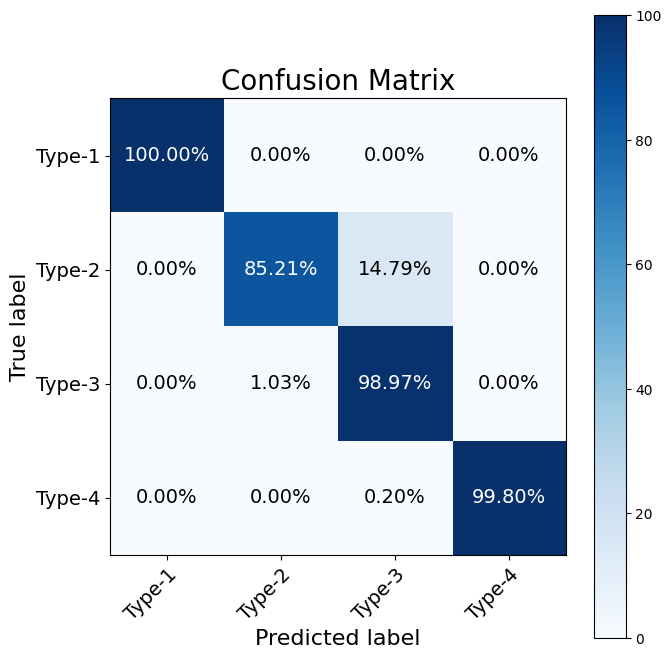

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Load the best model from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate the model to get predictions and true labels
def evaluate_and_get_predictions(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Generating Confusion Matrix"):
            graph_pair, labels = batch
            data1, data2 = graph_pair
            _, _, preds = model(data1.to(device), data2.to(device))

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Call the function to get predictions and true labels
true_labels, predictions = evaluate_and_get_predictions(model, valid_loader)

# Plot confusion matrix
def plot_confusion_matrix(y_trues, y_preds):
    # Generate confusion matrix
    cm = confusion_matrix(y_trues, y_preds)
    labels = ['Type-1', 'Type-2', 'Type-3', 'Type-4']

    # Convert confusion matrix to percentages
    cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    fig, ax = plt.subplots(figsize=(7, 7))  # Increase the size for better readability
    im = ax.imshow(cm_percentages, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Set font sizes
    plt.title('Confusion Matrix', fontsize=20)
    ax.set_xlabel('Predicted label', fontsize=16)
    ax.set_ylabel('True label', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'  # Format for the annotations
    thresh = cm_percentages.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm_percentages[i, j]:.2f}%",
                    ha="center", va="center",
                    color="white" if cm_percentages[i, j] > thresh else "black",
                    fontsize=14)  # Adjust font size for text annotations

    fig.tight_layout()
    plt.show()

# Plot the confusion matrix with predictions and true labels
plot_confusion_matrix(true_labels, predictions)
